In [1]:
# standard library imports
import csv
import ast
import datetime as dt
import json
import os
import statistics
import time

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
# third-party imports
import numpy as np
import pandas as pd

import requests
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import sklearn.metrics as metrics
import sklearn.cluster as cluster
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn import datasets
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import RegressorChain
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

/Users/longn/CodeStuffs/Kaggle/Store Prediction/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
np.random.seed(0)

In [4]:
holidays_events = pd.read_csv('holidays_events.csv')
# trainning_data = pd.read_csv('train.csv')
# test_data = pd.read_csv('test.csv')
stores_data = pd.read_csv('stores.csv')
transaction_data = pd.read_csv('transactions.csv')
oil_data = pd.read_csv('oil.csv')

In [59]:
print("\n Store Data:")
display(stores_data.head(5))

print("\n Holiday Data:")
display(holidays_events.head(5))

print("\n Transaction Data:")
display(transaction_data.head(5))

print("\n Oil Data:")
display(oil_data.head(5))


 Store Data:


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4



 Holiday Data:


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False



 Transaction Data:


,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922



 Oil Data:


,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [35]:
features = ['store_nbr','onpromotion']

In [58]:
trainning_data_store_sales = pd.concat([x for x in pd.read_csv('train.csv',
    parse_dates=['date'],
    chunksize=1000
)], ignore_index=True)

trainning_data_store_sales['sales'] = pd.to_numeric(trainning_data_store_sales['sales'], errors="coerce")
## For Testing
trainning_data_store_sales_backup = trainning_data_store_sales

In [8]:
test = pd.concat([x for x in pd.read_csv('test.csv',
    # dtype={
    #     'store_nbr': 'category',
    #     'family': 'category',
    #     'onpromotion': 'uint32',
    # },
    parse_dates=['date'],
    chunksize=1000

)], ignore_index=True)

## For Testing
test_backup = test


# step_count
# dir(step_count)
# test = test.set_index(['store_nbr', 'family', 'date']).sort_index()

Convert to DateTime for processing

In [9]:
trainning_data_store_sales['date'] = pd.to_datetime(trainning_data_store_sales['date'])


<h3>Step 2: Overview</h3>

Distribution Overview

<Axes: xlabel='sales', ylabel='Count'>

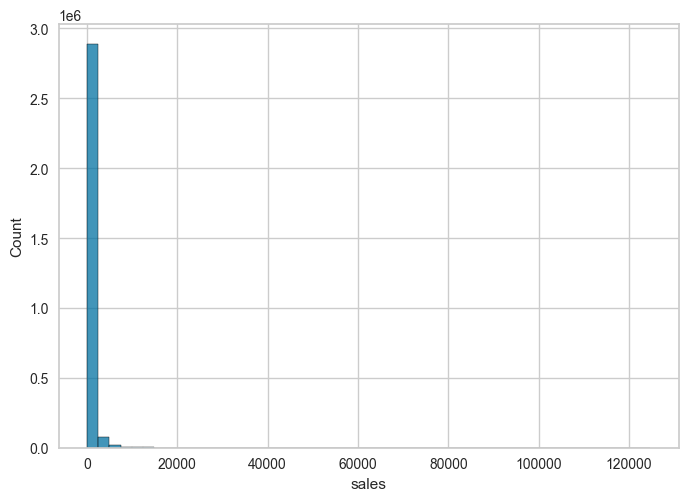

In [10]:
# sns.lineplot(data=trainning_data_store_sales, x="sales", y="date")
sns.histplot(trainning_data_store_sales['sales'], bins=50)

Trend of sales

In [11]:
plot_params = {'color': '0.75','style': '.-','markeredgecolor': '0.25','markerfacecolor': '0.25','legend': False}

In [52]:
average_sale = trainning_data_store_sales.groupby('date').mean('sales')

In [44]:
average_sale_by_date = trainning_data_store_sales.groupby('date').mean('sales')['sales']

In [ ]:
#  Plot: Overall Sales Trend Over Time
# trend = average_sale.rolling(
#     window=365,
#     center=True,
#     min_periods=183,
# ).mean()


fig = px.scatter(title="Trend of overall Sale",data_frame=average_sale_by_date, x=average_sale_by_date.index, y=average_sale_by_date.values, trendline="rolling", trendline_options=dict(window=365))
fig.data[1].update(line_color='red') 
fig.update_layout(
    xaxis_title="Time", yaxis_title="Sale"
)
fig.show()

### Using matplotlib
# plt.plot(average_sale.index, average_sale.values)
# plt.xlabel("Time",  size = 20)
# plt.ylabel("Sales", size = 20)
# plt.title("Trend Sales", size = 25)

# plt.plot(trend, color="red")


Overview of Sale by Store

In [15]:
merged_train_store_data = pd.merge(left=trainning_data_store_sales, right=stores_data, on='store_nbr')
display(merged_train_store_data.head(5))
display(trainning_data_store_sales.head(5))
display(stores_data.head(5))

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [ ]:
fig = px.box(merged_train_store_data, x="type", y="sales")
fig.show()

# Type D seems to have the highest sales overall.
# Box plot shows flat line because we are 

In [39]:
average_sale_store_nbr = trainning_data_store_sales.groupby('store_nbr').mean('sales')['sales']

In [60]:
fig = px.bar(title="Overall Sale based on Store", data_frame=average_sale_store_nbr, x=average_sale_store_nbr.index, y=average_sale_store_nbr.values)
fig.update_layout(
    xaxis_title="Store Id", yaxis_title="Sale"
)
fig.show()

# Store number 44 seems to have the highest sale. The plot indicates right-side (upper number stores) have an overall better sale --> Location-wise might be important?

<h3>Step 3: Check Seasonality</h3>

In [62]:
seasonal_data = trainning_data_store_sales
date = trainning_data_store_sales['date']
seasonal_data['month'] = date.dt.month
seasonal_data['year'] = date.dt.year


sale_based_on_month = trainning_data_store_sales.groupby(['year', 'month']).mean('sales')
sale_based_on_month

id  store_nbr       sales  onpromotion
year month                                               
2013 1        27620.5       27.5  186.952405     0.000000
     2        80189.5       27.5  193.581846     0.000000
     3       132758.5       27.5  206.880581     0.000000
     4       187109.5       27.5  205.639071     0.000000
     5       241460.5       27.5  209.943594     0.000000
     6       295811.5       27.5  218.655893     0.000000
     7       350162.5       27.5  203.783364     0.000000
     8       405404.5       27.5  212.479434     0.000000
     9       459755.5       27.5  220.593588     0.000000
     10      514106.5       27.5  213.164266     0.000000
     11      568457.5       27.5  231.136537     0.000000
     12      621917.5       27.5  295.606381     0.000000
2014 1       676268.5       27.5  342.341709     0.000000
     2       728837.5       27.5  241.268892     0.000000
     3       781406.5       27.5  368.661236     0.000000
     4       835757.5       27.5  240.577087     0.036270
     5       890108.5       27.5  242.203129     0.209533
     6       944459.5       27.5  249.157467     0.402095
     7       998810.5       27.5  351.578347     1.261088
     8      1054052.5       27.5  251.351805     0.777307
     9      1108403.5       27.5  374.530792     1.340423
     10     1162754.5       27.5  369.213666     1.392039
     11     1217105.5       27.5  384.056027     1.328732
     12     1270565.5       27.5  455.302177     1.719173
2015 1      1324916.5       27.5  269.666595     0.962094
     2      1377485.5       27.5  275.420792     0.816578
     3      1430054.5       27.5  282.368624     0.766808
     4      1484405.5       27.5  279.743138     1.017116
     5      1538756.5       27.5  320.958116     1.138301
     6      1593107.5       27.5  404.327728     1.829910
     7      1647458.5       27.5  402.042269     2.040875
     8      1702700.5       27.5  415.692304     1.911842
     9      1757051.5       27.5  434.734053     2.635110
     10     1811402.5       27.5  432.248428     2.085732
     11     1865753.5       27.5  426.579749     2.403610
     12     1919213.5       27.5  509.614322     2.487710
2016 1      1973564.5       27.5  434.050268     2.164621
     2      2027024.5       27.5  424.695398     3.551627
     3      2080484.5       27.5  418.735398     3.290793
     4      2134835.5       27.5  485.653294     4.027535
     5      2189186.5       27.5  448.561462     6.698146
     6      2243537.5       27.5  415.436187     5.338870
     7      2297888.5       27.5  424.725253     4.789924
     8      2353130.5       27.5  406.437390     4.916404
     9      2407481.5       27.5  419.331240     5.543603
     10     2461832.5       27.5  435.002169     6.707107
     11     2516183.5       27.5  460.954736     8.199738
     12     2569643.5       27.5  554.438600     9.680097
2017 1      2623994.5       27.5  476.596791     6.578835
     2      2676563.5       27.5  465.971468     5.957472
     3      2729132.5       27.5  483.400632     6.141903
     4      2783483.5       27.5  484.386616     6.940554
     5      2837834.5       27.5  487.162797     7.505992
     6      2892185.5       27.5  480.411936     7.380883
     7      2946536.5       27.5  488.966322     7.406104
     8      2987522.5       27.5  465.144891     5.996184

In [66]:
sale_based_on_month.index

MultiIndex([(2013,  1),
            (2013,  2),
            (2013,  3),
            (2013,  4),
            (2013,  5),
            (2013,  6),
            (2013,  7),
            (2013,  8),
            (2013,  9),
            (2013, 10),
            (2013, 11),
            (2013, 12),
            (2014,  1),
            (2014,  2),
            (2014,  3),
            (2014,  4),
            (2014,  5),
            (2014,  6),
            (2014,  7),
            (2014,  8),
            (2014,  9),
            (2014, 10),
            (2014, 11),
            (2014, 12),
            (2015,  1),
            (2015,  2),
            (2015,  3),
            (2015,  4),
            (2015,  5),
            (2015,  6),
            (2015,  7),
            (2015,  8),
            (2015,  9),
            (2015, 10),
            (2015, 11),
            (2015, 12),
            (2016,  1),
            (2016,  2),
            (2016,  3),
            (2016,  4),
            (2016,  5),
            (201

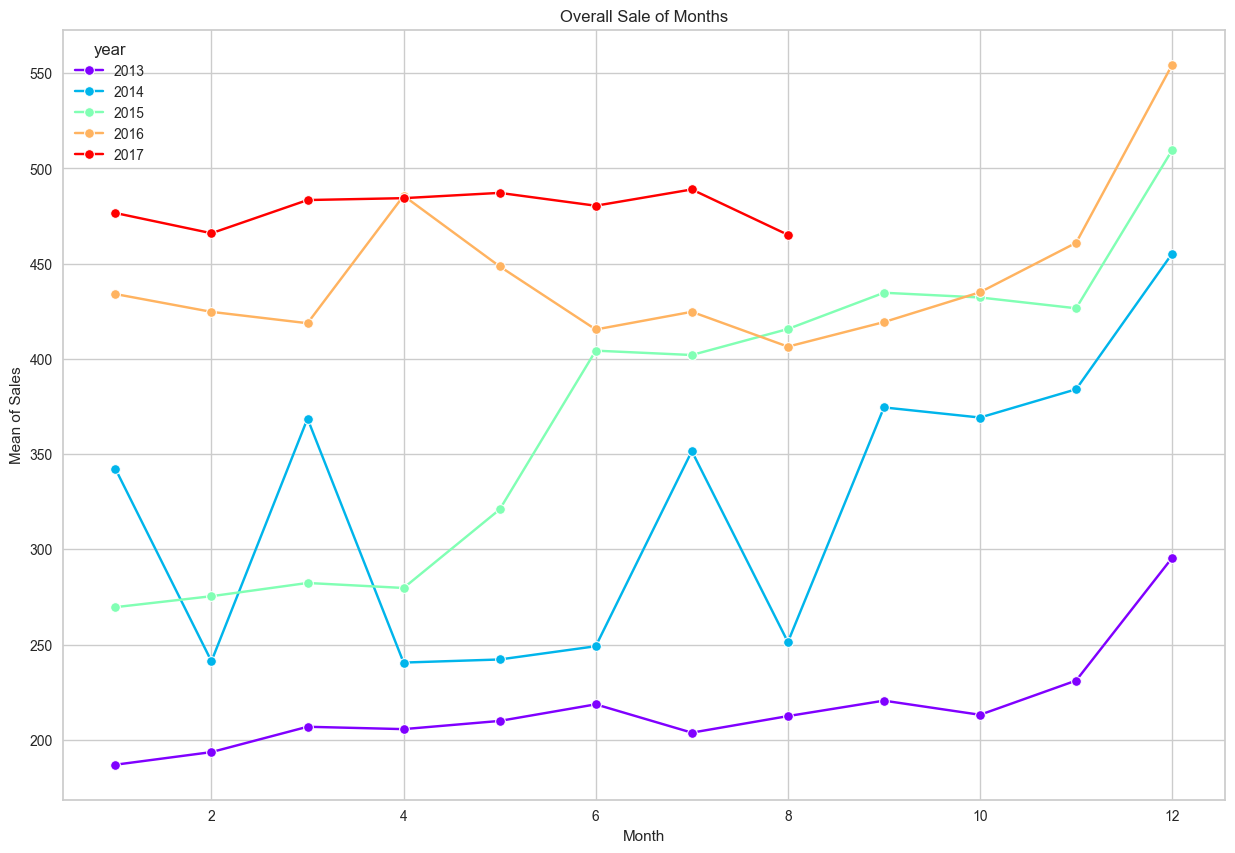

In [ ]:
plt.figure(figsize=(15,10))
sns.lineplot(data=sale_based_on_month, x='month', y='sales', hue='year',marker="o", palette="rainbow")
plt.xlabel("Month")
plt.ylabel("Mean of Sales")
plt.title("Overall Sale of Months")
plt.grid(True)
# px.line(data_frame=sale_based_on_month, x='month', y='sales', color='year')



## 2017 seems to have the least fluctuation in terms of Sale (hovers around 450-500)
## 2015 had the massive jump in sale over times  (from more than 250 at the beginning of the year --> 550 at the end of the year)

In [126]:
# Function to fit ARIMA models with different p (lags) and return AIC scores
def select_best_lag(time_series, max_lag):
    aic_values = []

    for p in range(1, max_lag + 1):
        model = ARIMA(time_series, order=(p, 0, 0))  # ARIMA(p, d, q) where d=0 for AR model
        model_fit = model.fit()
        aic_values.append((p, model_fit.aic))

    return aic_values

# Set max_lag to try and get the best lag based on AIC
max_lag = 10
aic_scores = select_best_lag(store_sales_lag, max_lag)

# Print the AIC values for different lags
for lag, aic in aic_scores:
    print(f'Lag: {lag}, AIC: {aic}')

# Find the lag with the minimum AIC value
best_lag = min(aic_scores, key=lambda x: x[1])[0]
print(f'\nOptimal Lag based on AIC: {best_lag}')

Lag: 1, AIC: 1292807.6624771259
Lag: 2, AIC: 1292539.0868848793
Lag: 3, AIC: 1292532.0280505298
Lag: 4, AIC: 1290634.1065865369
Lag: 5, AIC: 1285901.3787977176
Lag: 6, AIC: 1285523.1644179907
Lag: 7, AIC: 1285518.6329086635
Lag: 8, AIC: 1285070.23798433
Lag: 9, AIC: 1282555.9901864745
Lag: 10, AIC: 1281830.887272493

Optimal Lag based on AIC: 10


<h2>Step 3: Predict</h3>


In [22]:
best_lag = 25
step_count = 1

In [23]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)

def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)



def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax

In [ ]:
y = family_sales.loc[:, 'sales']

X = make_lags(y,lags=best_lag).dropna()

print(f'\nStep Count {step_count} with {best_lag} lags')

y = make_multistep_target(y, steps=step_count).dropna()

y, X = y.align(X, join='inner', axis=0)



Step Count 16 with 25 lags


In [56]:
le = LabelEncoder()
X = (X
    .stack('family')  # wide to long
    .reset_index('family')  # convert index to column
    .assign(family=lambda x: le.fit_transform(x.family))  # label encode
)
y = y.stack('family')  # wide to long

display(y)

/var/folders/lv/7cyrsyg90zs3cbgcjkk9mvsr0000gn/T/ipykernel_99416/3444948386.py:2: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  X = (X
/var/folders/lv/7cyrsyg90zs3cbgcjkk9mvsr0000gn/T/ipykernel_99416/3444948386.py:7: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  y = y.stack('family')  # wide to long


y_step_1     y_step_2     y_step_3  \
date       family                                                              
2017-01-26 AUTOMOTIVE                     4.907407     5.166667     8.166667   
           BABY CARE                      0.129630     0.277778     0.351852   
           BEAUTY                         3.500000     4.092593     6.962963   
           BEVERAGES                   2320.259277  2889.000000  4200.685059   
           BOOKS                          0.333333     0.500000     0.518519   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      364.955658   403.601349   377.313995   
           PREPARED FOODS                84.698647    87.836800    88.735970   
           PRODUCE                     2257.140625  2609.180176  3122.895752   
           SCHOOL AND OFFICE SUPPLIES    30.111111    49.333332    57.481480   
           SEAFOOD                       20.488333    20.346851    20.801037   

                                          y_step_4     y_step_5     y_step_6  \
date       family                                                              
2017-01-26 AUTOMOTIVE                     9.129630     6.111111     7.018518   
           BABY CARE                      0.444444     0.462963     0.370370   
           BEAUTY                         8.629630     4.518518     5.333333   
           BEVERAGES                   4765.870605  2873.907471  3058.722168   
           BOOKS                          0.388889     0.259259     0.370370   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      316.436096   533.497009   416.454041   
           PREPARED FOODS                77.172997    91.886765   100.384964   
           PRODUCE                     1792.220947  2079.319336  2418.970215   
           SCHOOL AND OFFICE SUPPLIES    51.907406    63.222221    85.203705   
           SEAFOOD                       17.116297    25.553965    24.209518   

                                          y_step_7     y_step_8     y_step_9  \
date       family                                                              
2017-01-26 AUTOMOTIVE                     7.611111     6.518518     7.185185   
           BABY CARE                      0.240741     0.388889     0.388889   
           BEAUTY                         6.333333     5.185185     5.018518   
           BEVERAGES                   3560.018555  2870.666748  3209.370361   
           BOOKS                          0.574074     0.500000     0.425926   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      464.596558   344.051758   313.780884   
           PREPARED FOODS               102.248146    86.627441    77.344131   
           PRODUCE                     2675.105957  2111.133301  2168.535400   
           SCHOOL AND OFFICE SUPPLIES   100.277779    64.407410    59.759258   
           SEAFOOD                       23.512852    18.419851    18.481131   

                                         y_step_10    y_step_11    y_step_12  \
date       family                                                              
2017-01-26 AUTOMOTIVE                    12.407408    10.703704     6.740741   
           BABY CARE                      0.407407     0.574074     0.277778   
           BEAUTY                         9.907408     8.666667     4.574074   
           BEVERAGES                   4749.074219  4907.962891  3176.611084   
           BOOKS                          0.537037     0.722222     0.462963   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      305.270233   278.819885   468.857391   
           PREPARED FOODS                84.796539    78.791443    96.286926   
           PRODUCE                     2663.076416  1670.264893  2198.854492   
           SCHOOL AND OFFICE SUPPLIES  

<h3>Step 4: Model Prediction<h3>

In [26]:
model = RegressorChain(base_estimator=XGBRegressor())

model

RegressorChain(base_estimator=XGBRegressor(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,
                                           max_cat_threshold=None,
                                           max_cat_to_onehot=None,
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...))

In [45]:
y

y_step_1
date       family                                 
2017-01-26 AUTOMOTIVE                     4.907407
           BABY CARE                      0.129630
           BEAUTY                         3.500000
           BEVERAGES                   2320.259277
           BOOKS                          0.333333
...                                            ...
2017-08-15 POULTRY                      325.679840
           PREPARED FOODS                85.954132
           PRODUCE                     2316.832764
           SCHOOL AND OFFICE SUPPLIES    46.851852
           SEAFOOD                       17.966240

[6666 rows x 1 columns]

In [79]:
model.fit(X, y)

test['date']

# y_pred = pd.DataFrame(
#     model.predict(test.stack('family')),
#     index=y.index,
#     columns=y.columns,
# ).clip(0.0)


KeyError: 'date'

In [89]:
test['id']

store_nbr  family      date      
1          AUTOMOTIVE  2017-08-16    3000888
                       2017-08-17    3002670
                       2017-08-18    3004452
                       2017-08-19    3006234
                       2017-08-20    3008016
                                      ...   
9          SEAFOOD     2017-08-27    3022271
                       2017-08-28    3024053
                       2017-08-29    3025835
                       2017-08-30    3027617
                       2017-08-31    3029399
Name: id, Length: 28512, dtype: int64

In [73]:
testNew = (test
    .stack('family')  # wide to long
    .reset_index('family')  # convert index to column
    .assign(family=lambda x: le.fit_transform(x.family))  # label encode
)

KeyError: 'Requested level (family) does not match index name (None)'

In [ ]:
model.predict()

/Users/longn/CodeStuffs/Kaggle/Store Prediction/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RegressorChain was fitted with feature names
  warnings.warn(


ValueError: Expected a 2-dimensional container but got <class 'pandas.core.series.Series'> instead. Pass a DataFrame containing a single row (i.e. single sample) or a single column (i.e. single feature) instead.

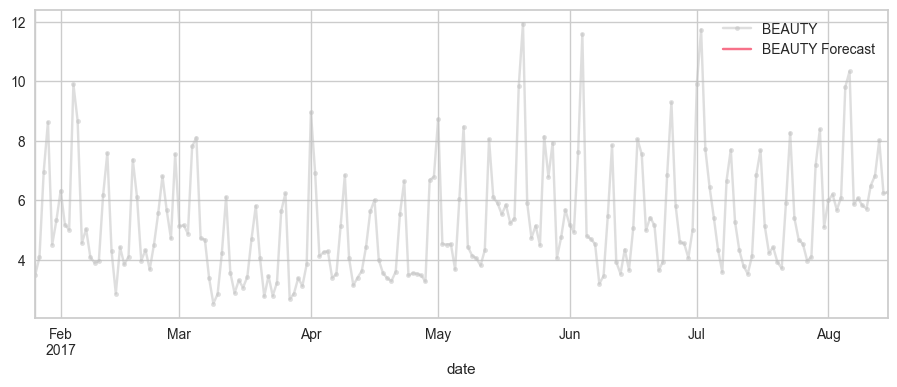

In [31]:
FAMILY = 'BEAUTY'
START = '2017-01-26'
EVERY = 25
plot_params = {"color": "0.75", "style":".-"}

y_pred_ = y_pred.xs(FAMILY, level='family', axis=0).loc[START:]
y_ = family_sales.loc[START:, 'sales'].loc[:, FAMILY]

y_pred.xs(FAMILY, level='family', axis=0)

fig, ax = plt.subplots(1, 1, figsize=(11, 4))
ax = y_.plot(**plot_params, ax=ax, alpha=0.5)
ax = plot_multistep(y_pred_, ax=ax, every=EVERY)
_ = ax.legend([FAMILY, FAMILY + ' Forecast'])